In [46]:
import numpy as np
import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import seaborn as sns

import tqdm

## Learning a simple function

Let's try to learn a Gaussian

In [10]:
pi = torch.tensor(np.pi)

def Gauss(x):
    if type(x) == np.ndarray:
        x = torch.tensor(x)
        
    return 1 / (2*pi) * torch.exp( - x**2 / 2 )

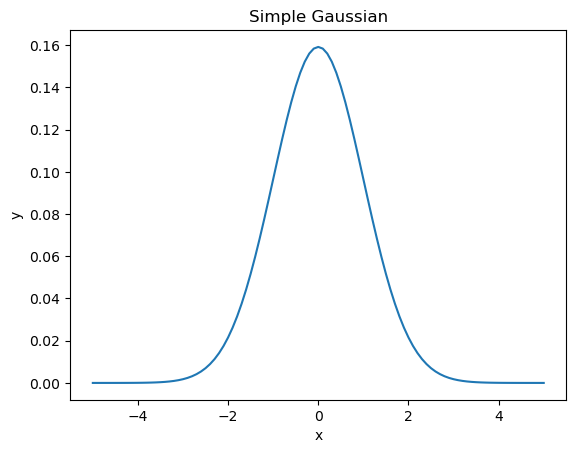

In [14]:
# PLOT

x = np.linspace(-5,5,101)
y = Gauss(x)

plt.plot(x,y)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Simple Gaussian');

In [84]:
# SIMPLE LINEAR MODEL

class LinModel(nn.Module):

    def __init__(self):
        super().__init__()

        self.linear_ReLu_stack = nn.Sequential(
            nn.Linear(in_features=1,out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128,out_features=1),
            nn.ReLU(),
        )

    def forward(self,x):
        return self.linear_ReLu_stack(x)
    
# DEFINING MODEL

lin_model = LinModel()
print(lin_model)


LinModel(
  (linear_ReLu_stack): Sequential(
    (0): Linear(in_features=1, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
    (3): ReLU()
  )
)


In [85]:
# DATA
X = torch.linspace(-7,7,1001).view(-1,1)
y = Gauss(X)


In [88]:
# TRAINING

# TRAIN TEST SPLIT
train_size = int(0.8 * len(X))  
val_size = len(X) - train_size  
train_idx, val_idx = torch.utils.data.random_split(X, [train_size, val_size])
train_idx = train_idx.indices
val_idx = val_idx.indices
X_train = X[train_idx]
X_val = X[val_idx]
y_train = y[train_idx]
y_val = y[val_idx]

# OPTIMIZER
optimizer = optim.Adam(lin_model.parameters(),lr=1e-4)

# EXTERNAL PARAMETERS
n_epochs = 500
loss_fct = nn.MSELoss()
train_losses = []
val_losses = []
val_acc = []


# TRAINING + VALIDATION
for epochs in range(n_epochs):
    optimizer.zero_grad()

    # TRAINING
    pred_train = lin_model(X_train) 
    loss_train = loss_fct(pred_train,y_train)
    loss_train.backward()
    optimizer.step()

    train_losses.append(loss_train.item())

    # VALIDATION
    with torch.no_grad():
        pred_val = lin_model(X_val)
        loss_val = loss_fct(pred_val,y_val)
        val_losses.append(loss_val)

# INFERENCE
with torch.no_grad():
    predictions = lin_model(X)



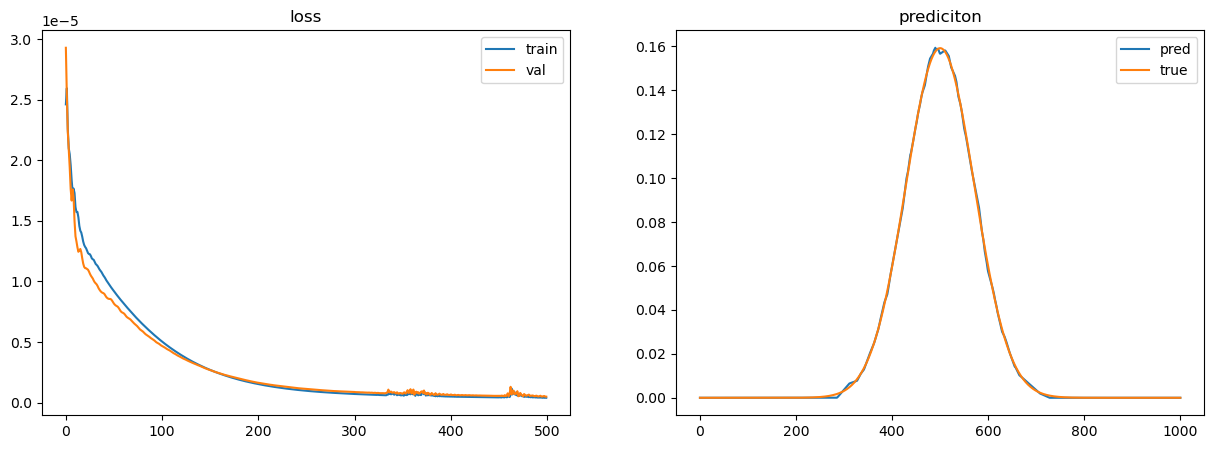

In [89]:

fig, ax = plt.subplots(ncols=2,nrows=1,figsize=(15,5))

ax[0].plot(train_losses,label='train')
ax[0].plot(val_losses,label='val')
ax[0].legend()
ax[0].set_title('loss');

ax[1].plot(predictions,label='pred')
ax[1].plot(y,label='true')
ax[1].legend()
ax[1].set_title('prediciton');


## Learning XOR


XOR: $[0,1]^2 \to [0,1]$ not-linear saperable!

XOR(0,0) = XOR(1,1) = 0
XOR(1,0) = XOR(0,1) = 1

In [230]:
X = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]],dtype=torch.float32) # possible input states
y = torch.tensor([0,1,1,0],dtype=torch.float32) # possible output states 

print(f'{X.shape = }')
print(f'{y.shape = }')
print('\n')
print(f'{X.dtype = }')
print(f'{y.dtype = }')

X.shape = torch.Size([4, 2])
y.shape = torch.Size([4])


X.dtype = torch.float32
y.dtype = torch.float32


In [10]:
# XOR MODEL
class XORModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.xor_stack = nn.Sequential(
            nn.Linear(in_features=2,out_features=16),
            nn.Tanh(),
            nn.Linear(in_features=16,out_features=1),
            nn.Tanh(),
        )

    def forward(self,x):
        return self.xor_stack(x)

xor_model = XORModel()
print(xor_model)

XORModel(
  (xor_stack): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): Tanh()
    (2): Linear(in_features=16, out_features=1, bias=True)
    (3): Tanh()
  )
)


100%|██████████| 10000/10000 [00:01<00:00, 6877.58it/s]


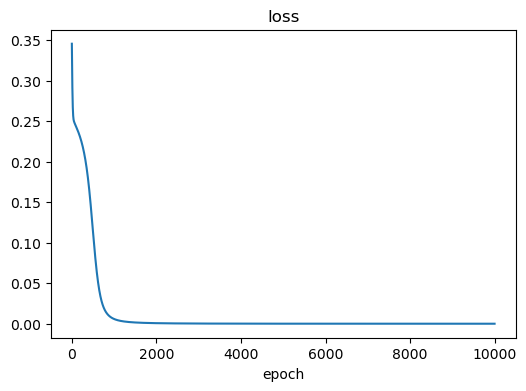

In [11]:
X = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]],dtype=torch.float32) # possible input states
y = torch.tensor([[0],[1],[1],[0]],dtype=torch.float32) # possible output states 

xor_model = XORModel()

optimizer = optim.Adam(xor_model.parameters())

loss_fct = nn.MSELoss()
losses = []

n_epochs = 10_000

for epoch in tqdm.tqdm(range(n_epochs)):
    optimizer.zero_grad()

    pred = xor_model(X) # forward pass
    loss = loss_fct(pred,y)
    loss.backward() # back propagation
    optimizer.step() # update params

    losses.append(loss.item())


fig = plt.figure(figsize=(6,4))
plt.plot(losses)
plt.title('loss')
plt.xlabel('epoch');


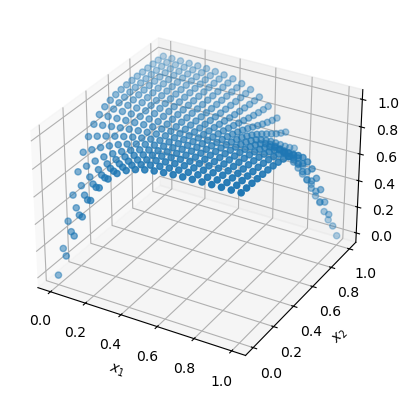

In [12]:
# DICISION BOUNDARY
x1 = torch.linspace(0,1,21)
x2 = torch.linspace(0,1,21)

xx,yy = torch.meshgrid(x1,x2,indexing='ij')
pts = torch.stack([xx.ravel(),yy.ravel()],dim=1)

z = xor_model(pts).detach().view(len(x1),len(x2)) # detach 


# PLOT DICISION BOUNDARY
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(xx,yy,z,marker='o')
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$');


## 1d CNN learning Sin

From pytorch doc for Conv1d: 

L_out = floor( L_in + 2*Padding - dilation(kernel_size - 1) / stride ) + 1


For padding = 0 (same as padding='valid'), dilation = 1, stride = 1 one gets

L_out = floor(L_in - (kernel_size - 1)) + 1

In [68]:
class CNN1d(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=1,out_channels=8,kernel_size=3),
            nn.Conv1d(in_channels=8,out_channels=16,kernel_size=5),
            nn.Flatten(),
            nn.Linear(in_features= 16*(101 - 3 - 5 + 2),out_features=64),
            nn.Tanh(),
            nn.Linear(in_features=64,out_features=101),
            nn.Tanh()
        )

    def forward(self,x):
        return self.cnn(x)
    

cnn_model = CNN1d()
print(cnn_model)

CNN1d(
  (cnn): Sequential(
    (0): Conv1d(1, 8, kernel_size=(3,), stride=(1,))
    (1): Conv1d(8, 16, kernel_size=(5,), stride=(1,))
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Linear(in_features=1520, out_features=64, bias=True)
    (4): Tanh()
    (5): Linear(in_features=64, out_features=101, bias=True)
    (6): Tanh()
  )
)


100%|██████████| 10000/10000 [00:14<00:00, 697.90it/s]


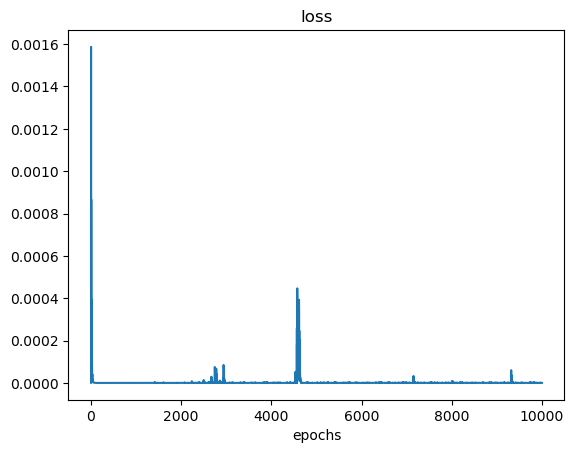

In [86]:
# DATA
pi = torch.tensor(np.pi)

X = torch.linspace(0,4*pi,101).view(1,1,-1) # (batch,channels,seq_len)
y = torch.sin(X)

# TRAINING

optimizer = optim.Adam(cnn_model.parameters())
loss_fct = nn.MSELoss()
losses = []

n_epochs = 10_000

for epochs in tqdm.tqdm(range(n_epochs)):
    optimizer.zero_grad()

    pred = cnn_model(X) # forward pass
    loss = loss_fct(pred,y.squeeze(dim=0)) # y.shape = (1,1,101)
    loss.backward() # backpropagation
    optimizer.step() # update parameters

    losses.append(loss.item())


plt.title('loss')
plt.xlabel('epochs')
plt.plot(losses)


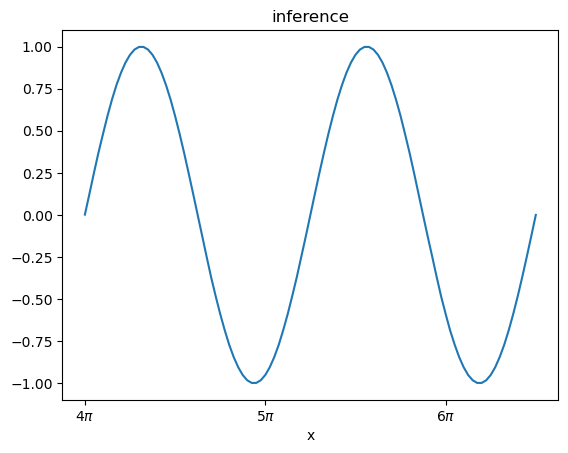

In [ ]:
t0 = 4*pi
t1 = 6.5*pi

x_new = torch.linspace(t0,t1,101).view(1,1,-1) # new x-values
t = x_new.flatten()

yhat = cnn_model(x_new).detach().flatten() # inference

pi_ticks = np.arange(t0,t1,pi)
pi_ticks_labels = [f"{int(n/pi)}$\pi$" if n != 0 else '0' for n in pi_ticks]

plt.title('inference')
plt.xlabel('x')
plt.xticks(ticks=pi_ticks,labels=pi_ticks_labels)
plt.plot(t,yhat);

### Adding some noise to test for outliers

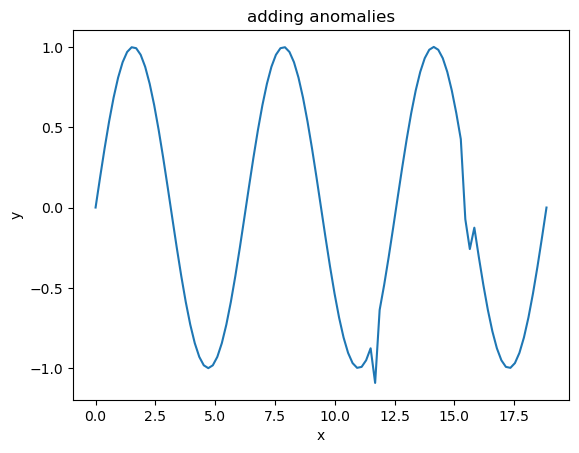

In [101]:
# DATA
pi = torch.tensor(np.pi)
steps = 101
X = torch.linspace(0,6*pi,steps).view(1,1,-1) # (batch,channels,seq_len)
y = torch.sin(X)


torch.manual_seed(57) 
rnd_idx = torch.randint(0,steps,size=(3,))

y[...,rnd_idx] += torch.randn(1)


plt.title('adding anomalies')
plt.plot(X.flatten(),y.flatten())
plt.xlabel('x')
plt.ylabel('y');

100%|██████████| 100/100 [00:00<00:00, 631.39it/s]


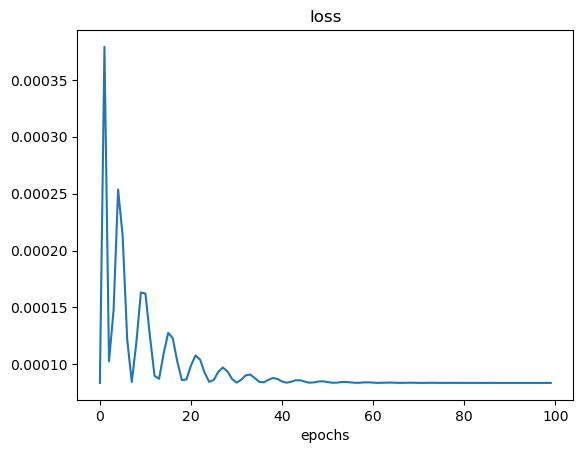

In [110]:
# TRAINING

optimizer = optim.Adam(cnn_model.parameters())
loss_fct = nn.MSELoss()
losses = []

n_epochs = 100

for epochs in tqdm.tqdm(range(n_epochs)):
    optimizer.zero_grad()

    pred = cnn_model(X) # forward pass
    loss = loss_fct(pred,y.squeeze(dim=0)) # y.shape = (1,1,101)
    loss.backward() # backpropagation
    optimizer.step() # update parameters

    losses.append(loss.item())


# PLOT LOSS
plt.title('loss')
plt.xlabel('epochs')
plt.plot(losses);

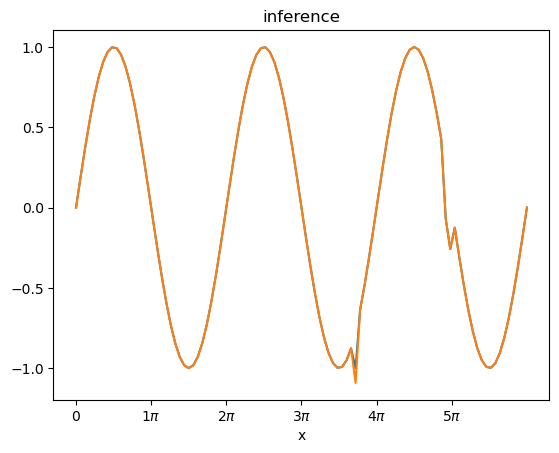

In [111]:
# INFERENCE
t0 = 0*pi
t1 = 6*pi

x_new = torch.linspace(t0,t1,101).view(1,1,-1) # new x-values
t = x_new.flatten()

yhat = cnn_model(x_new).detach().flatten() # inference

pi_ticks = np.arange(t0,t1,pi)
pi_ticks_labels = [f"{int(n/pi)}$\pi$" if n != 0 else '0' for n in pi_ticks]

plt.title('inference')
plt.xlabel('x')
plt.xticks(ticks=pi_ticks,labels=pi_ticks_labels)
plt.plot(t,yhat,label=r'$\hat y$')
plt.plot(t,y.flatten());

## Image Classification MNIST

In [160]:
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
print(f'{torchvision.__version__ = }')

torchvision.__version__ = '0.20.1'


In [100]:
# (VANILLA) LOAD MNIST DATA
train_dataset = torchvision.datasets.MNIST(root='./data',train=True)

images = train_dataset.data
targets = train_dataset.targets

print(f'{type(images) = }')
print(f'{type(targets) = }\n')
print(f'{images.shape = }')
print(f'{targets.shape = }\n')
print(f'{images[0].dtype = }\n')
print(f'{images[0].max() = }')
print(f'{images[0].min() = }\n')

# MANUAL PRE-PROCESSING
prepping = transforms.Compose([
    transforms.Lambda(lambda x: x.float()), # convert to float
    transforms.Lambda(lambda x: x.unsqueeze(dim=0)),  # add channels: (H, W) -> (1, H, W)
    transforms.Lambda(lambda x: x/255.), # scale
    transforms.Normalize(mean=(0.5,),std=(0.5,)) # normalize to [-1, 1]
]) 

images = torch.stack([prepping(img) for img in images])

print(f'{type(images) = }')
print(f'{type(targets) = }\n')
print(f'{images.shape = }')
print(f'{targets.shape = }\n')
print(f'{images[0].dtype = }\n')
print(f'{images[0].max() = }')
print(f'{images[0].min() = }\n')

type(images) = <class 'torch.Tensor'>
type(targets) = <class 'torch.Tensor'>

images.shape = torch.Size([60000, 28, 28])
targets.shape = torch.Size([60000])

images[0].dtype = torch.uint8

images[0].max() = tensor(255, dtype=torch.uint8)
images[0].min() = tensor(0, dtype=torch.uint8)



In [165]:
# PRE-PROCESSING WHEN LOADING DATA

# PREPPING PIPELINE
prepping = transforms.Compose([
    transforms.ToTensor(),  # uint8 (H, W) -> float (C, H, W) in [0, 1]
    transforms.Normalize(mean=(0.5,), std=(0.5,))  # Normalize to [-1, 1]
])

# LOAD & PREP
dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=prepping, # apply preprocessing pipeline
    download=False
)

# IMGS & TARGETS
images = torch.stack([dataset[i][0] for i in range(len(dataset))])
targets = torch.tensor([dataset[i][1] for i in range(len(dataset))])

# SANITY CHECK
print(f'{type(images) = }')
print(f'{type(targets) = }\n')
print(f'{images.shape = }')
print(f'{targets.shape = }\n')
print(f'{images[0].dtype = }\n')
print(f'{images[0].max() = }')
print(f'{images[0].min() = }\n')


type(images) = <class 'torch.Tensor'>
type(targets) = <class 'torch.Tensor'>

images.shape = torch.Size([60000, 1, 28, 28])
targets.shape = torch.Size([60000])

images[0].dtype = torch.float32

images[0].max() = tensor(1.)
images[0].min() = tensor(-1.)



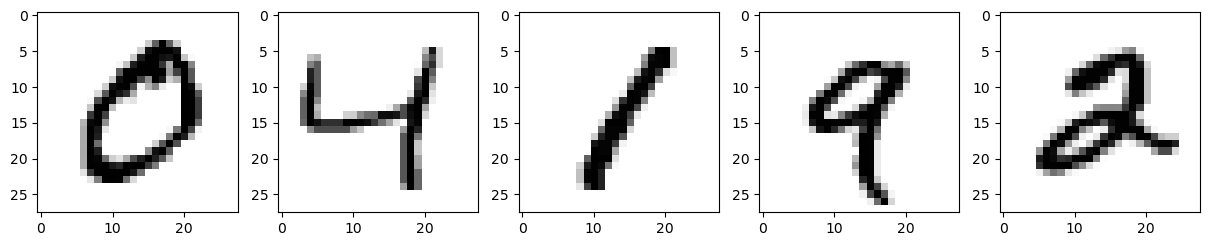

In [111]:
# PLOT FIRST COUPLE OF IMAGES
fig = plt.figure(figsize=(15,4))

for i in range(1,6):
    plt.subplot(1,5,i)
    plt.imshow(train_dataset.data[i],cmap='gray_r')

In [125]:
# MODEL CLASS
class CNN2d(nn.Module):
    def __init__(self):
        super().__init__()

        
        self.conv_stack = nn.Sequential(
            # generally preserve dims if padding = (kernel_size - 1)/2
            nn.Conv2d(in_channels=1,out_channels=16,kernel_size=3,stride=1,padding=1), # (28,28) -> (28,28)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2)), # (28,28) -> (14,14)

            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1), # (14,14) -> (14,14)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2)), # (14,14) -> (7,7)
        )

        self.classification_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=32*7*7,out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128,out_features=10) # 10 classes
        )

    def forward(self,x):
        x = self.conv_stack(x)
        x = self.classification_stack(x)

        return x
    

In [221]:
# USE GPU IF AVAILABLE
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

model = CNN2d().to(device)

print(model)

CNN2d(
  (conv_stack): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (classification_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1568, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [222]:
# USE GPU IF AVAILABLE
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = model.to(device)

# TRAIN-TEST SPLIT
rndgen = torch.Generator().manual_seed(57)

train_size = int(0.8 * len(dataset))  # nb data for training
val_size = len(dataset) - train_size  # nb data for validation

train_set, val_set = torch.utils.data.random_split(dataset,lengths=[train_size, val_size],generator=rndgen) # rnd split of dataset (imgs,targets)

# BATCHING SETUP
batch_size = 64
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

# TRAINING PARAMETERS
loss_fct = nn.CrossEntropyLoss()
lr = 1e-4
optimizer = optim.Adam(model.parameters(), lr=lr)

n_epochs = 10

losses_train = []
losses_val = []
acc = []

for epoch in tqdm.tqdm(range(n_epochs),desc="Epochs", total=n_epochs):
    optimizer.zero_grad()

    # TRAINING
    model.train() # set model in training mode

    batch_loss = 0
    
    for batch_idx, (x,y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device) # push to GPU

        logits = model(x) # forward pass
        loss = loss_fct(logits,y) # loss
        loss.backward() # backpropagation
        optimizer.step() # update params
    
        batch_loss += loss.item() 

    losses_train.append(batch_loss/len(train_loader)) # avg loss per epoch

    # VALIDATION
    model.eval()
    with torch.no_grad():
        batch_loss_val = 0
        correct = 0
        total = 0
 
        for x,y in val_loader:
            x, y = x.to(device), y.to(device) # push to GPU
            logits_val = model(x)
            loss_val = loss_fct(logits_val,y)
            batch_loss_val += loss_val.item()

            yhat = logits_val.argmax(dim=1) # prediciton
            correct += (yhat == y).sum().item()
            total += batch_size
            
        losses_val.append(batch_loss_val/len(train_loader)) # avg loss per epoch
        acc.append(correct/total)
    

Epochs: 100%|██████████| 10/10 [01:15<00:00,  7.53s/it]


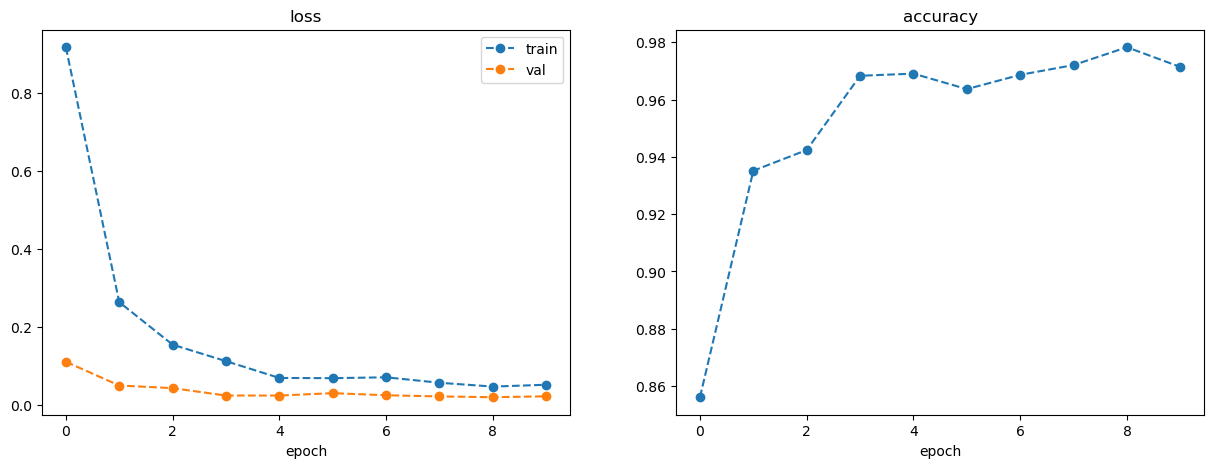

In [223]:
fig = plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(torch.tensor(losses_train),'o',ls='--',label='train')
plt.plot(torch.tensor(losses_val),'o',ls='--',label='val')
plt.title('loss')
plt.xlabel('epoch')
plt.legend();

plt.subplot(1,2,2)
plt.plot(torch.tensor(acc),'o',ls='--')
plt.title('accuracy')
plt.xlabel('epoch');

In [288]:
# CHECKING TYPES AND SIZES
x0 = val_set[0][0].to(device)
y0 = val_set[0][1]
y0hat = model(x0.unsqueeze(0)).detach().to('cpu').flatten() # 

print('images')
print(f'{type(x0) = }')
print(f'{x0.shape = }')
print(f"{type(y0hat) = }")
print(f'{y0hat.shape = }')

print('\n')
print('targets')
print(f'{type(y0) = }')



images
type(x0) = <class 'torch.Tensor'>
x0.shape = torch.Size([1, 28, 28])
type(y0hat) = <class 'torch.Tensor'>
y0hat.shape = torch.Size([10])


targets
type(y0) = <class 'int'>


In [310]:
# INFERENCE
prep_for_inference = transforms.Compose([
    transforms.Lambda(lambda x: x.to(device)), # send to device
    transforms.Lambda(lambda x: x.unsqueeze(dim=0)),  # add batch dim
    transforms.Lambda(lambda x: model(x)), # predict
    transforms.Lambda(lambda x: x.detach()), # detach
    transforms.Lambda(lambda x: x.to('cpu')), # send to cpu
    transforms.Lambda(lambda x: x.flatten()), # flatten
    transforms.Lambda(lambda x: x.argmax().item()), # argmax
]) 

y_true = [val_set[i][1] for i in range(len(val_set))] # true targets: list[int]
y_hat =  [prep_for_inference(val_set[i][0]) for i in range(len(val_set))] # prediction: list[int]


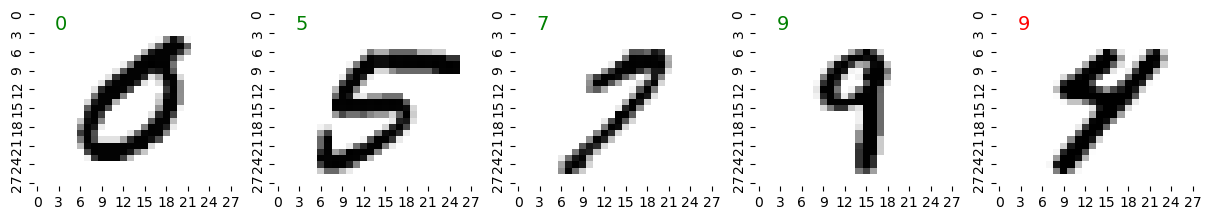

In [311]:
fig = plt.figure(figsize=(15,5))
for i in range(1,6):
    plt.subplot(2,5,i)
    sns.heatmap(val_set[i][0].squeeze(0),cmap='gray_r',cbar=False)
    color = 'g' if y_batch[i] == y_true[i] else 'r'
    plt.text(x=3,y=3,s=f'{y_batch[i]}',color=color,fontsize=14)

In [309]:
# CONFUSION MATRIX
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

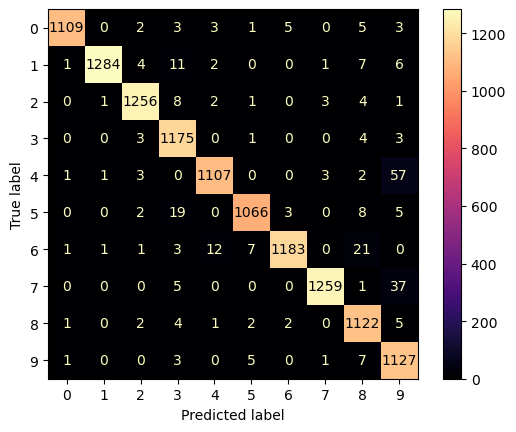

In [313]:
cm = confusion_matrix(y_true=y_true, y_pred=y_hat)
ConfusionMatrixDisplay(cm).plot(cmap='magma');